# 3D reconstruction
+ 3D reconstruction is an important application for spatial alignment. 
+ In this case we use 3d-OT to rebuild 3D structure from multiple mouse E11.5-E16.5 embryo Stereo-seq slices data

## Loading package

In [1]:
from lib_3d_OT.utils import *
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from lib_3d_OT.threeDrecon import *
from lib_3d_OT.plot import *
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.3.2 
2: package ‘datasets’ was built under R version 4.3.2 
3: package ‘utils’ was built under R version 4.3.2 
4: package ‘grDevices’ was built under R version 4.3.2 
5: package ‘graphics’ was built under R version 4.3.2 
6: package ‘stats’ was built under R version 4.3.2 
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



Could not load compiled 3D CUDA chamfer distance


In [2]:
import os
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

## loading data

In [4]:
adata1=sc.read_h5ad('/home/dbj/mouse/oT/different-time/E11.5.h5ad')
adata1.obs['truth']=adata1.obs['annotation']

adata2=sc.read_h5ad('/home/dbj/mouse/oT/different-time/E12.5.h5ad')
adata2.obs['truth']=adata2.obs['annotation']

adata3=sc.read_h5ad('/home/dbj/mouse/oT/different-time/E13.5.h5ad')
adata3.obs['truth']=adata3.obs['annotation']

adata4=sc.read_h5ad('/home/dbj/mouse/oT/different-time/E14.5.h5ad')
adata4.obs['truth']=adata4.obs['annotation']

adata5=sc.read_h5ad('/home/dbj/mouse/oT/different-time/E15.5.h5ad')
adata5.obs['truth']=adata5.obs['annotation']

adata6=sc.read_h5ad('/home/dbj/mouse/oT/different-time/E16.5.h5ad')
adata6.obs['truth']=adata6.obs['annotation']


## We visualize every dataset in 2D before alignment

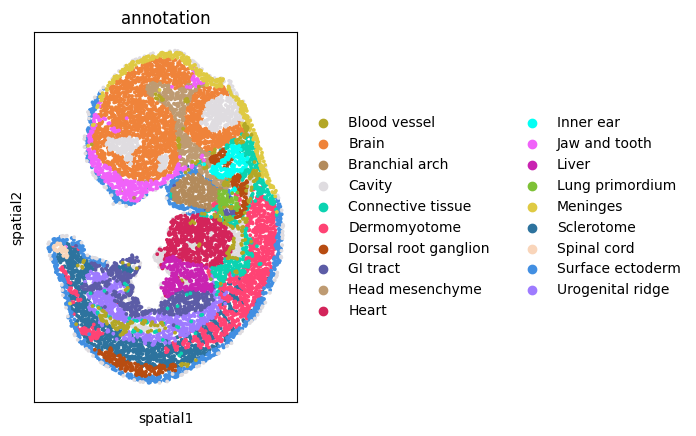

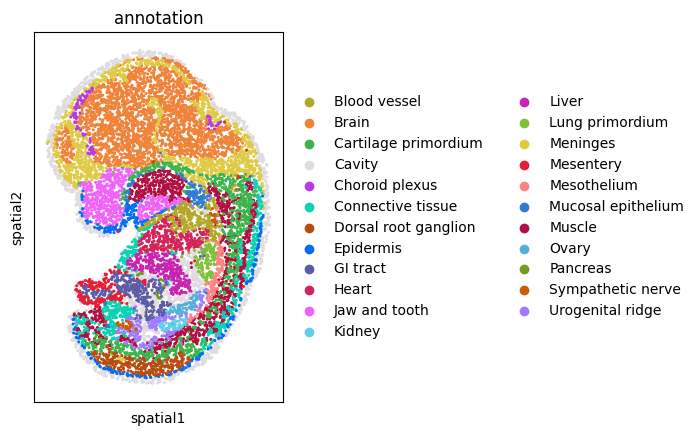

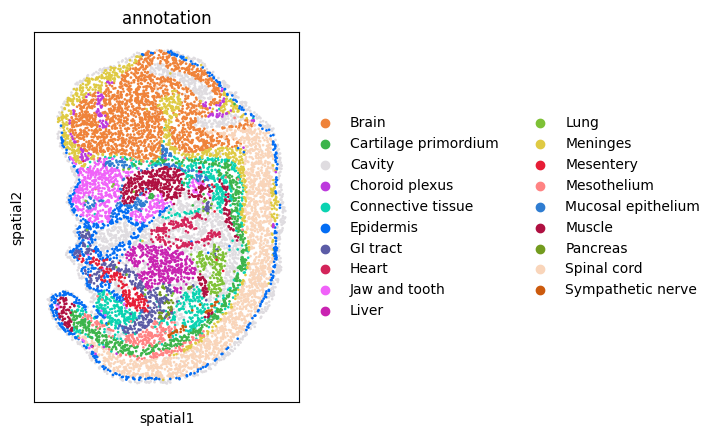

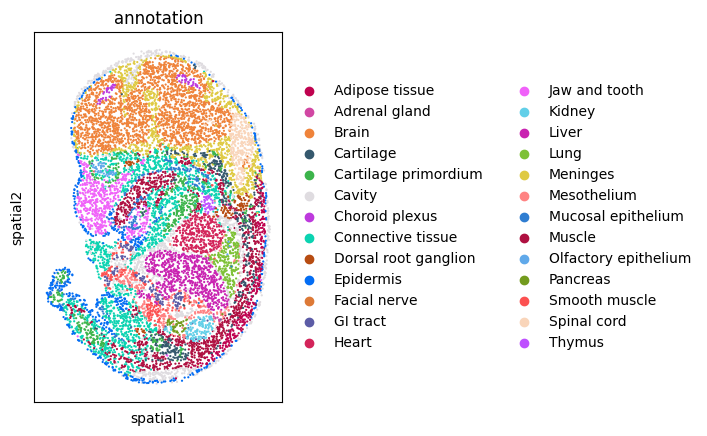

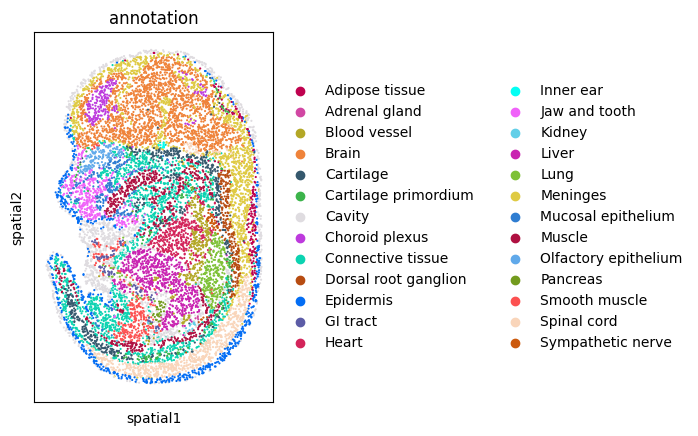

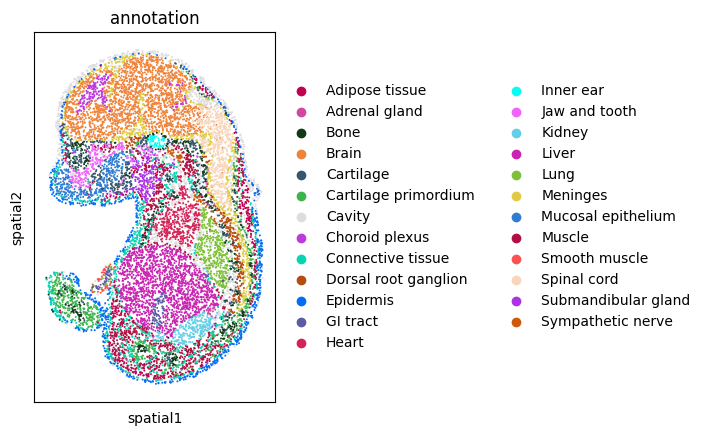

In [5]:
sc.pl.spatial(adata1, spot_size=3, color='annotation')
sc.pl.spatial(adata2, spot_size=3, color='annotation')
sc.pl.spatial(adata3, spot_size=3, color='annotation')
sc.pl.spatial(adata4, spot_size=3, color='annotation')
sc.pl.spatial(adata5, spot_size=3, color='annotation')
sc.pl.spatial(adata6, spot_size=3, color='annotation')

## Building spatiotemporal developmental trajectory using 3d-OT
+ Training encoder between adjacent slices

In [7]:
adatalist = [adata1, adata2, adata3, adata4, adata5, adata6]
corrected_adatas, graphs, best_models = pairwise_dpca_and_train(adatalist, join='inner', n_comps=50, neighbors=6,epochs=800,device=device)
pclouds_list = graphs

Processing pair: 0 -> 1
Epoch 800/800, Loss: 1.360324, Min Loss: 1.350767Training time for adata0 in pair 0->1: 33.33 seconds
Epoch 800/800, Loss: 1.299219, Min Loss: 1.265533Training time for adata1 in pair 0->1: 28.92 seconds
Processing pair: 1 -> 2
Epoch 800/800, Loss: 1.195852, Min Loss: 1.195245Training time for adata1 in pair 1->2: 30.43 seconds
Epoch 800/800, Loss: 1.591694, Min Loss: 1.591643Training time for adata2 in pair 1->2: 30.21 seconds
Processing pair: 2 -> 3
Epoch 800/800, Loss: 1.538934, Min Loss: 1.537077Training time for adata2 in pair 2->3: 29.61 seconds
Epoch 800/800, Loss: 1.274691, Min Loss: 1.246992Training time for adata3 in pair 2->3: 31.59 seconds
Processing pair: 3 -> 4
Epoch 800/800, Loss: 1.234406, Min Loss: 1.220684Training time for adata3 in pair 3->4: 30.37 seconds
Epoch 800/800, Loss: 1.518229, Min Loss: 1.501579Training time for adata4 in pair 3->4: 33.00 seconds
Processing pair: 4 -> 5
Epoch 800/800, Loss: 1.594596, Min Loss: 1.571328Training time f

+ Align all slices

In [23]:
aligned_models = pairwise_align_reverse(graphs, best_models, device=device, nb_epochs=1,simk=2,otk=500)

Aligning pair: graph1 -> graph0 (Pair 0)
Time Pair 0,total_loss: 0.1150,smooth_flow_loss: 0.0712 Target Recon Loss: 0.00010835,Div Flow Loss: 0.0437Aligning pair: graph3 -> graph2 (Pair 1)
Time Pair 0,total_loss: 0.1426,smooth_flow_loss: 0.0721 Target Recon Loss: 0.00006128,Div Flow Loss: 0.0704Aligning pair: graph5 -> graph4 (Pair 2)
Time Pair 0,total_loss: 0.1394,smooth_flow_loss: 0.0722 Target Recon Loss: 0.00015596,Div Flow Loss: 0.0670Aligning pair: graph7 -> graph6 (Pair 3)
Time Pair 0,total_loss: 0.1392,smooth_flow_loss: 0.0763 Target Recon Loss: 0.00005303,Div Flow Loss: 0.0628Aligning pair: graph9 -> graph8 (Pair 4)
Time Pair 0,total_loss: 0.1233,smooth_flow_loss: 0.0780 Target Recon Loss: 0.00010411,Div Flow Loss: 0.0452

## Visualize the temporal developmental trajectory of the Heart

pair: graph1 -> graph0
pair: graph3 -> graph2
pair: graph5 -> graph4
pair: graph7 -> graph6
pair: graph9 -> graph8


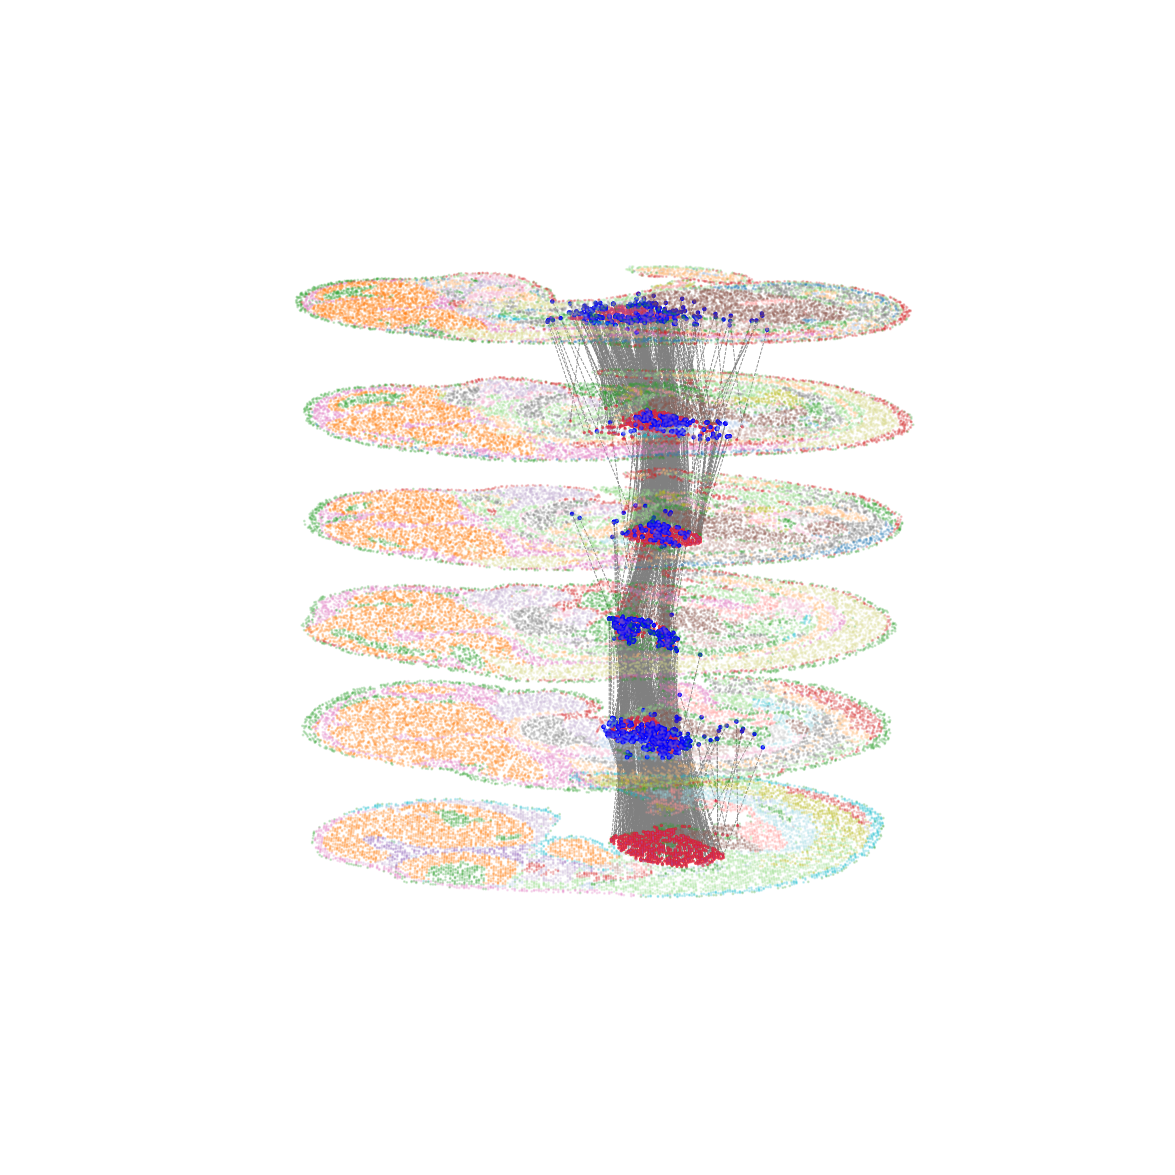

In [24]:
all_arrow_ends= plot_all_pairs_cell_type_flow(graphs=graphs,aligned_models=aligned_models,device=device,finaltruth='Heart',selected_cell_type="Heart",
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    height_scale=1.0,
    #save_path="/home/dbj/mouse/flow_plots/all_pairs_flow.png"
)


## Visualize the temporal developmental trajectory of the Liver

pair: graph1 -> graph0
pair: graph3 -> graph2
pair: graph5 -> graph4
pair: graph7 -> graph6
pair: graph9 -> graph8


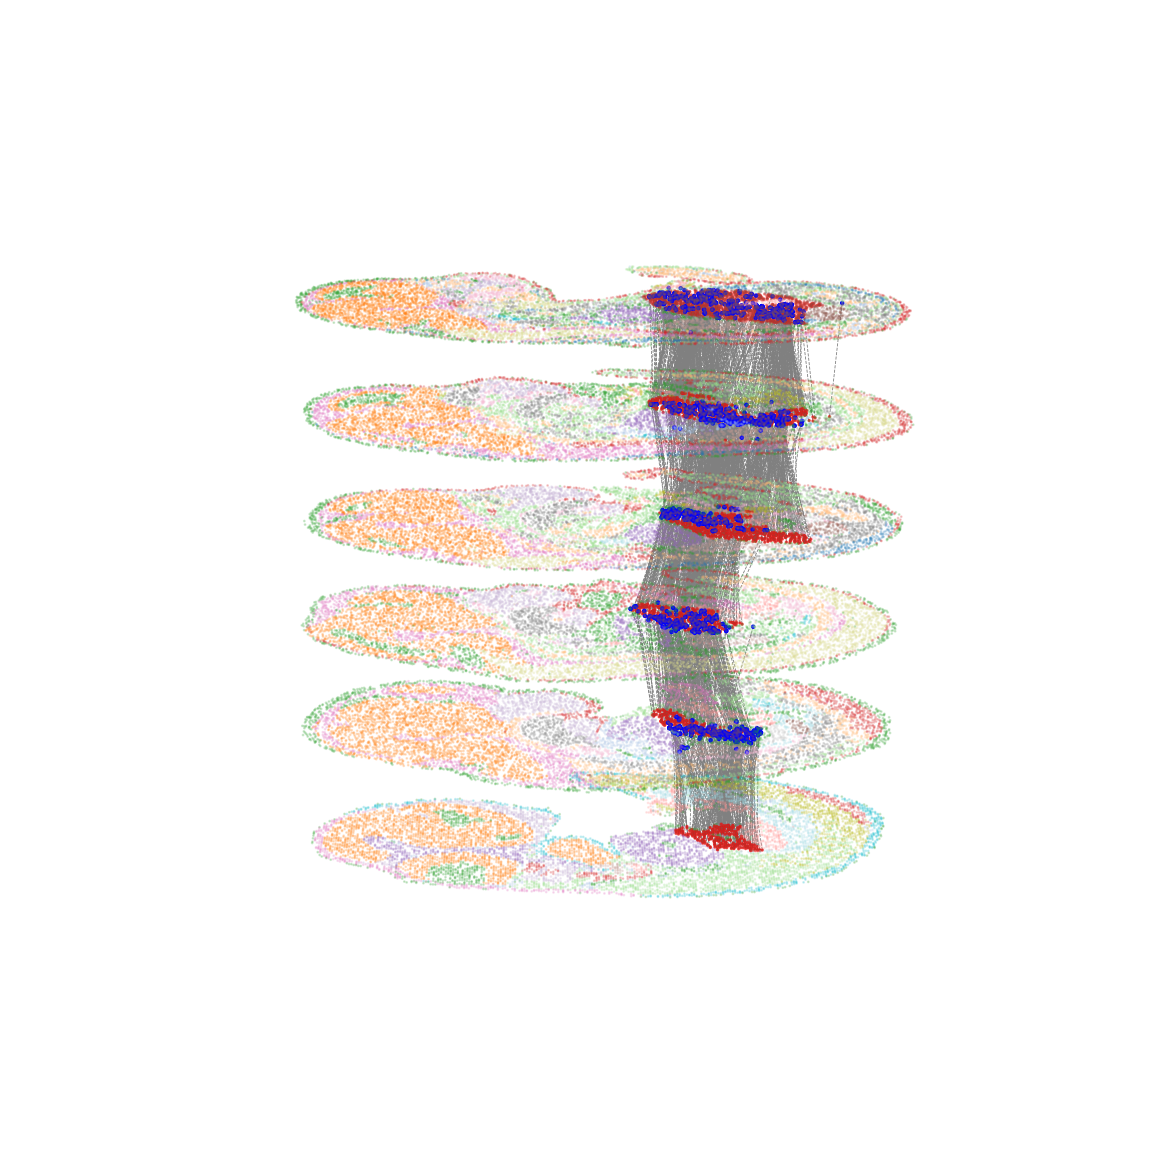

In [25]:
all_arrow_ends= plot_all_pairs_cell_type_flow(graphs=graphs,aligned_models=aligned_models,device=device,finaltruth='Liver',selected_cell_type="Liver",
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    height_scale=1.0,
    #save_path="/home/dbj/mouse/flow_plots/all_pairs_flow.png"
)